In [25]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/')
import netCDF4
import fill_values as fv
import datetime
import calc_date as cd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import save_fig as sF
import createFolder as cF
from matplotlib.gridspec import GridSpec
import plt_ce_image as im
import read_MRR as pMRR
import plot_sfc_spaghetti_ret as spagh


from scipy.integrate import simps
import matplotlib as mpl

In [26]:
year = '2016'
month = '12'
#t = ['17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
t = ['20', '21', '22', '23', '24', '25', '26', '27']
tid = '00'
station = 'Haukeliseter'


### Figures 
savefig = 0
figdir = '../../Figures/Retrieval_MEPS/RMSE/_48'

cF.createFolder('%s/' %(figdir))

form = 'png'
################################################################
### MEPS
level = 'sfc'
nc_dir_sfc = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
level = 'ml'
nc_dir_ml = '../../Data/MEPS/%s/%s_%s' %(station,level,tid)
# air temperature
var_name_air_temp = 'air_temperature_ml'
air_temp_dir = '%s/%s' %(nc_dir_ml,var_name_air_temp)
# snow fall amount
var_name_snow = 'snowfall_amount_ml'
snow_dir = '%s/%s' %(nc_dir_ml,var_name_snow)
# graupel fall amount
var_name_graupel = 'graupelfall_amount_ml'
graupel_dir = '%s/%s' %(nc_dir_ml,var_name_graupel)
# atmosphere_cloud_ice_content_ml
var_name_cl_ice = 'atmosphere_cloud_ice_content_ml'
cl_ice_dir = '%s/%s' %(nc_dir_ml,var_name_cl_ice)

################################################################
### MRR
MRR_dir = '../../Data/MRR/processed_MRR'

################################################################
### Retrieval 
nc_dir_retrieval = '../../Data/Retrieved_SWC'

################################################################

In [27]:
no5 = np.array([157,58,55])/255.

In [28]:
## MRR ######
fnMRR      = dict()
time_MRR   = dict()
height_MRR = dict()
Ze         = dict()

In [29]:
## RETRIEVAL ######
fnRet      = dict()
retrieved_snowfall_amount = dict()
SWC        = dict()
SWP_ret    = dict() 
SWC_con    = dict()
time_con   = dict()
SWP_mean_ret= dict()

In [30]:
air_temp_file     = dict()
snow_file         = dict()
graupel_file      = dict()
cl_ice_file       = dict()

fn_air_temp       = dict()
fn_snow           = dict()
fn_graupel        = dict()
fn_cl_ice         = dict()

time_ml           = dict()
air_temp_ml       = dict()
pressure_ml       = dict()
snow_amount_ml    = dict()
graupel_amount_ml = dict()
cl_ice_ml         = dict()

thickness_ml      = dict()
ice_amount_ml     = dict()
time              = dict()
height_ml         = dict()
height            = dict()
density_ml        = dict()
SWP_model         = dict()
time_SWP          = dict()

In [31]:
Rd = 287.    # gas constant for dry air [J kg^-1 K^-1]

In [32]:
for day in t:
## MRR ######  
    fnMRR[day] = netCDF4.Dataset('%s/VMRR_%s%s%s.nc' %(MRR_dir,year,month,day) ,'r')
    time_MRR[day]   = fnMRR[day].variables['time'][:]
    height_MRR[day] = fnMRR[day].variables['height'][:]

    Ze[day] = pMRR.read_and_mask(fnMRR[day],'Ze', np.nan)         # vertical Ze profile for retrieval

## RETRIEVAL ######
    fnRet[day] = netCDF4.Dataset('%s/out_swc_b6_%s%s%s.nc' %(nc_dir_retrieval, year, month, day))

    retrieved_snowfall_amount[day] = fnRet[day].variables['retrieved_snowfall_amount'][:]
    SWC[day] = fnRet[day].variables['SWC'][:]
    
    swpret = []
    swpret = simps(SWC[day][:,:], height_MRR[day], axis = 0)
    SWP_ret[day] = swpret


### hourly SWC 
mean_SWC = dict()
for day in t:
    if day == '20':
        time_con[day]= np.concatenate((time_MRR[day], time_MRR[str(int(day)+1)][:30]))
        SWC_con[day] = np.concatenate((SWC[day], SWC[str(int(day)+1)][:,:30]),axis=1)
    elif day == '27':
        time_con[day]= np.concatenate((time_MRR[str(int(day)-1)][23*60+30:], time_MRR[day]))
        SWC_con[day] = np.concatenate((SWC[str(int(day)-1)][:,23*60+30:], SWC[day]),axis=1)
    else:
        time_con[day]= np.concatenate((time_MRR[str(int(day)-1)][23*60+30:], time_MRR[day], time_MRR[str(int(day)+1)][:30]))
        SWC_con[day] = np.concatenate((SWC[str(int(day)-1)][:,23*60+30:], SWC[day], SWC[str(int(day)+1)][:,:30]),axis=1)
    
    avg60 = []
    if day == '20':
        for i in range(30,SWC_con[day].shape[1],60):
            avg60.append(np.nanmean(SWC_con[day][:,i:(i+60)],axis=1))
        mean_SWC[day] = np.transpose(avg60)
    else:
        for i in range(0,SWC_con[day].shape[1],60):
            avg60.append(np.nanmean(SWC_con[day][:,i:(i+60)],axis=1))
        mean_SWC[day] = np.transpose(avg60)

### hourly SWP
    swpret = []
    swpret = simps(mean_SWC[day][:,:], height_MRR[day], axis = 0)
    SWP_mean_ret[day] = swpret

# for plotting, only values larger than 0.01
    a,b = np.where(retrieved_snowfall_amount[day][:,:] < 0.01)
    SWC[day][a[:],b[:]]                       = np.nan
    retrieved_snowfall_amount[day][a[:],b[:]] = np.nan
    np.transpose(Ze[day])[a[:],b[:]]          = np.nan
#    mean_SWC[day][a[:],b[:]]                  = np.nan
    a1,b1 = np.where(mean_SWC[day][:,:] < 0.01)    
    mean_SWC[day][a1[:],b1[:]] = np.nan
    
    fnMRR[day].close()
    fnRet[day].close()

/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/read_MRR.py:95: RuntimeWarning: invalid value encountered in less
  mask = np.ma.getmaskarray(var[:,:])
/Volumes/SANDISK128/Documents/Thesis/Python/Retrieval/read_MRR.py:96: RuntimeWarning: invalid value encountered in less
  var = np.ma.array(var[:,:], mask = mask, fill_value = fill_value)


In [33]:
# layer for average snow water content within 200 m
nlay= 15
bot = []
top = []
for k in range(0, nlay):
    bot.append(100.+ k*200)
    top.append(bot[k]+200)

avg_SWC_ml = dict()
h_avg      = dict()
t_avg      = dict()

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater_equal
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in greater
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:143: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 67 but corresponding boolean dimension is 15
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_laun

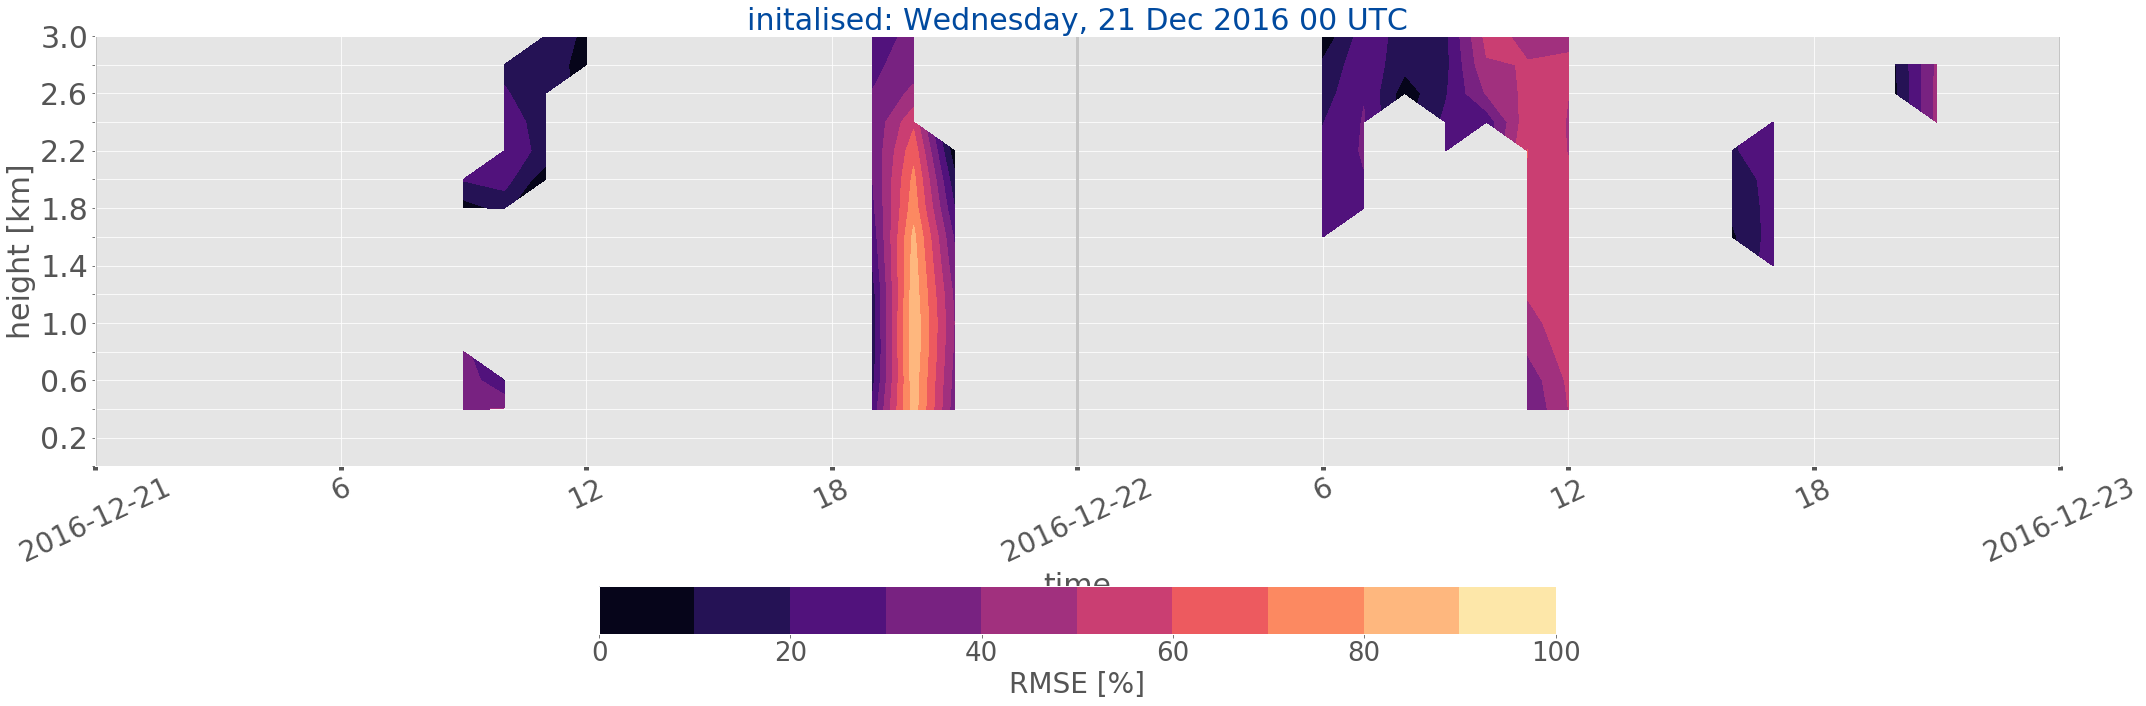

In [56]:
#for k in range(0,np.asarray(t).shape[0]-1):
for k in range(1,2):
    day = t[k]
## MEPS ######
    for ens_memb in range(0,10):
        air_temp_file[ens_memb]= '%s/%s%s%s_%s_%s.nc' %(air_temp_dir,year,month,day,tid,ens_memb)
        snow_file[ens_memb]    = '%s/%s%s%s_%s_%s.nc' %(snow_dir,year,month,day,tid,ens_memb)
        graupel_file[ens_memb] = '%s/%s%s%s_%s_%s.nc' %(graupel_dir,year,month,day,tid,ens_memb)
        cl_ice_file[ens_memb]  = '%s/%s%s%s_%s_%s.nc' %(cl_ice_dir,year,month,day,tid,ens_memb)
        
        fn_air_temp[ens_memb]  = netCDF4.Dataset(air_temp_file[ens_memb])
        fn_snow[ens_memb]      = netCDF4.Dataset(snow_file[ens_memb])
        fn_graupel[ens_memb]   = netCDF4.Dataset(graupel_file[ens_memb]) 
        fn_cl_ice[ens_memb]    = netCDF4.Dataset(cl_ice_file[ens_memb])

# Read in time to know initialisation time (plotting)    
        time_ml[ens_memb] = fn_snow[ens_memb].variables['time']
        time_ml[ens_memb] = fv.fill_nan(time_ml[ens_memb][:])
        

        ini_day = datetime.datetime.utcfromtimestamp(time_ml[0][0]).day   # day of initialisation
        hh = datetime.datetime.utcfromtimestamp(time_ml[0][0]).hour       # first hour of initialisation?
        calday, calmon = cd.get_dayname(year, month, ini_day)
        
# Read in the pressure, and the air temperature to calculate ice amount from [kg/kg] to [kg/m^3]
        air_temp_ml[ens_memb] = fn_air_temp[ens_memb].variables[var_name_air_temp]
        pressure_ml[ens_memb] = fn_snow[ens_memb].variables['pressure_ml']
# Read in the variable name which should be plotted  
        snow_amount_ml[ens_memb]    = fn_snow[ens_memb].variables[var_name_snow]
        graupel_amount_ml[ens_memb] = fn_graupel[ens_memb].variables[var_name_graupel]
        cl_ice_ml[ens_memb]         = fn_cl_ice[ens_memb].variables[var_name_cl_ice]


# create an array with time of the shape of the variable
        lead_time   = np.arange(0,snow_amount_ml[ens_memb].shape[0])
        model_level = np.arange(0,snow_amount_ml[ens_memb].shape[1])
        td,Y        = np.meshgrid(lead_time,model_level)

# substitute missing values with nan 
        pressure_ml[ens_memb]       = fv.fill_nan(pressure_ml[ens_memb][:])
        air_temp_ml[ens_memb]       = fv.fill_nan(air_temp_ml[ens_memb][:])
        snow_amount_ml[ens_memb]    = fv.fill_nan(snow_amount_ml[ens_memb][:])
        graupel_amount_ml[ens_memb] = fv.fill_nan(graupel_amount_ml[ens_memb][:])
        cl_ice_ml[ens_memb]         = fv.fill_nan(cl_ice_ml[ens_memb][:])
# get ice amount (snow+graupel)
        ice_amount_ml[ens_memb]     = snow_amount_ml[ens_memb] + graupel_amount_ml[ens_memb] + cl_ice_ml[ens_memb]

    
# layer thickness to calculate height
        thickness_ml[ens_memb]      = fn_snow[ens_memb].variables['layer_thickness']
        thickness_ml[ens_memb]      = fv.fill_nan(thickness_ml[ens_memb][:])
    
        thickness = thickness_ml[ens_memb]
        h_above = []
        h_above.append(np.zeros(thickness[:,:].shape[0]))
        th_arr = np.nansum([np.asarray(h_above)[:,0], thickness[:,0]], axis = 0)
        h_above.append(th_arr)
        for i in range(2,thickness[:,:].shape[1]):
            th_arr = np.nansum([h_above[i-1], thickness[:,i-1]], axis = 0)
            h_above.append(th_arr)
        height_ml[ens_memb] = np.transpose(h_above) 
        
        
####
# calculate density at each level
        density_ml[ens_memb] = pressure_ml[ens_memb]/(Rd*air_temp_ml[ens_memb])
              

# convert from [kg/kg] to [kg/m^3]
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*density_ml[ens_memb])

# convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
        ice_amount_ml[ens_memb] = (ice_amount_ml[ens_memb]*1000.)
    
    
# calculate mean of snowfall amount in each layer, every 200m
        SWC_ml = []
        h_mid = []
        for k in range(0, nlay):
            tidx,hidx = np.where(np.logical_and(height_ml[ens_memb][:,:] >= bot[k], height_ml[ens_memb][:,:] < top[k]))
# average in layer
            SWC_ml.append(np.nanmean(ice_amount_ml[ens_memb][:,hidx[:]], axis = 1))
            h_mid.append((bot[k]+top[k])/2)
        avg_SWC_ml[ens_memb] = SWC_ml      
        
        time[ens_memb]          = td
        height[ens_memb]        = height_ml[ens_memb]   
        
        hidx = []
        tidx = []
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[1]):
            hidx.append(h_mid)
        h_avg[ens_memb] = hidx
        for i in range(0,np.asarray(avg_SWC_ml[ens_memb]).shape[0]):
            tidx.append(time[ens_memb][0,:])
        t_avg[ens_memb] = tidx

 ### snow water path        
        SWP_ml = []
        SWP_ml_mean = []
        for i in range(0,np.transpose(avg_SWC_ml[ens_memb]).shape[0]):
            SWP_ml.append(simps(y = np.transpose(avg_SWC_ml[ens_memb])[i,:], 
                            x = np.asarray(h_avg[ens_memb])[i,:]))
        SWP_model[ens_memb] = SWP_ml
        
        
        
## only use values below 3km
        h1, h2 = np.where(height[ens_memb][:,:] > 3000)
        ice_amount_ml[ens_memb][h1[:],h2[:]] = np.nan
        time[ens_memb][h2[:],h1[:]]          = -9999
        height[ens_memb][h1[:],h2[:]]        = np.nan
        
        
               

    val = np.zeros(shape=(10,np.asarray(avg_SWC_ml[0]).shape[0]))
    val2= np.zeros(shape=(10,np.asarray(SWP_model[0]).shape[0]))
#    ice_EM = []
    ice_mean = []
    SWP_mean_ml = []
    ice_std = []
    variable = []
# calculate the ensemble mean of ice amount (all 10 ensemble member averaged)
    for k in range(0,ice_amount_ml[0].shape[0]):
#    for k in range(0,25):
#    for k in range(0,1):
        for ens_memb in range(0,10):
            val[ens_memb] = (np.transpose(avg_SWC_ml[ens_memb])[k,:])
            val2[ens_memb]= (np.transpose(SWP_model[ens_memb])[:])

        variable.append(val)
    ### std, mean
        ice_std.append(np.nanstd(val,axis=0,ddof=1))  
        ice_mean.append(np.nanmean(val,axis=0))
        SWP_mean_ml = (np.nanmean(val2,axis=0))



# get only valuable values not nan   
    for ens_memb in range(0,10):
        time_ml[ens_memb]       = (time_ml[ens_memb][~np.isnan(time_ml[ens_memb])])
        time[ens_memb]          = (td[:,~np.isnan(avg_SWC_ml[ens_memb]).any(axis=1)])
        height[ens_memb]        = (height_ml[ens_memb][~np.isnan(avg_SWC_ml[ens_memb]).any(axis=1),:])
        thickness_ml[ens_memb]  = (thickness_ml[ens_memb][~np.isnan(avg_SWC_ml[ens_memb]).any(axis=1),:]) 
        air_temp_ml[ens_memb]   = (air_temp_ml[ens_memb][~np.isnan(avg_SWC_ml[ens_memb]).any(axis=1),:])
        pressure_ml[ens_memb]   = (pressure_ml[ens_memb][~np.isnan(avg_SWC_ml[ens_memb]).any(axis=1),:])
        
 #       avg_SWC_ml[ens_memb]    = (avg_SWC_ml[ens_memb][:,~np.isnan(avg_SWC_ml[ens_memb]).any(axis=0)])
        time_SWP[ens_memb]      = (td[:,~np.isnan(SWP_model[ens_memb])])
        SWP_model[ens_memb]     = np.asarray(SWP_model[ens_memb])[~np.isnan(np.asarray(SWP_model[ens_memb]))]
        
        


###################################################################################
### merge the values of two retrieval days 
    if Ze[day].shape[0] > 1440:
   #     print('Ze ==', Ze[day].shape[0])
        df1 = Ze[day][:-1]
        df2 = Ze[str(int(day)+1)][1::,:]
    elif Ze[str(int(day)+1)].shape[0] > 1440:
  #      print('Ze(day+1) == ', Ze[str(int(day)+1)].shape[0])
        df1 = Ze[day]
        df2 = Ze[str(int(day)+1)][1:-1,:]
    else:
        df1 = Ze[day]
        df2 = Ze[str(int(day)+1)][1::,:]
    mergedZe = []
    mergedZe.extend(df1)
    mergedZe.extend(df2)

    np.asarray(mergedZe).shape

    mergedSWC = []
    mergedSWC.extend(np.transpose(SWC[day]))
    mergedSWC.extend(np.transpose(SWC[str(int(day)+1)][:,1::][:]))
    
    np.asarray(mergedSWC).shape
    
    merged_mean_SWC = []
    merged_mean_SWC.extend(np.transpose(mean_SWC[day]))
    merged_mean_SWC.extend(np.transpose(mean_SWC[str(int(day)+1)][:,1::][:]))
    np.asarray(merged_mean_SWC).max()
    np.asarray(merged_mean_SWC).shape
    

    mergedSWP = []
    mergedSWP.extend(SWP_ret[day])
    mergedSWP.extend(SWP_ret[str(int(day)+1)][1::][:])
    
    merged_mean_SWP = []
    merged_mean_SWP.extend(SWP_mean_ret[day])
    merged_mean_SWP.extend(SWP_mean_ret[str(int(day)+1)][1::][:])

    np.asarray(mergedSWP).max()
    np.asarray(mergedSWP).shape
    
    np.asarray(merged_mean_SWP).max()
    np.asarray(merged_mean_SWP).shape
    

   
    

### RMSE = sqrt(mean((forecast - observation)^2))
    if day == '20':
        squared = (np.asarray(ice_mean)[:48,1:] - np.asarray(merged_mean_SWC))
    else:
        squared = (np.asarray(ice_mean)[:49,1:] - np.asarray(merged_mean_SWC))
    #mean_squared = np.mean(squared)
    RMSE = np.sqrt(squared)*100 


###########################################################################
### PLOTTING ###########
    xdays = ['%s-%s-%s' %(year,month,ini_day), 
        6,12, 18,
        '%s-%s-%s' %(year,month,ini_day+1), 
        6, 12, 18,
        '%s-%s-%s' %(year,month,ini_day+2)]

    mpl.style.use('ggplot')


####### RMSE plot ##########
    fig_name = '%s%s%s.%s' %(year,month,ini_day,form)
    fig = plt.figure(1, figsize=(30,10))
    ax = fig.add_subplot(111)
# Vertical line to show end of day
    ax.axvline(0,color = spagh.vert_col, linewidth = 3)
    ax.axvline(24,color = spagh.vert_col, linewidth = 3)
    ax.axvline(48,color = spagh.vert_col, linewidth = 3)
    levels = np.arange(0,100,10)

    xticks=np.arange(0,49,6)
    yticks=im.yticks1
    xlabel=xdays

    levels3 = np.arange(0,110,10)
    if day == '20':
        Xmax = 48
    else:
        Xmax = 49
    im0 = ax.contourf(np.transpose(t_avg[0])[:Xmax,1:], np.asarray(h_avg[0])[:Xmax,1:], (RMSE),levels3,
                      #cmap='seismic', extend = 'max', 
                      cmap='magma',# extend = 'max', 
                      alpha = 1.0, 
                       vmin = 0., vmax = 100., origin = 'lower')

# set the limits of the plot to the limits of the data
    ax.axis([0., 48, 0., 3000.])

# labels 
    im.labels_x(ax,xticks,xlabel)
    im.labels_y(ax,yticks,im.yl1,'height [km]')
    im.add_colorbar(fig,im0, ax, levels3[::2] ,var_label='RMSE [%]')


    if hh < 10:
        hh = '0%s' %(hh)
    else:
        hh = '%s' %(hh)
# title
    title = 'initalised: %s, %s %s %s %s UTC' %(calday,ini_day,calmon,year,hh)
    ax.set_title(title, fontsize=im.fontsize+2, color =im.date_blue )
# tight layout
    fig.tight_layout(pad=1.4,  h_pad=2.5)
    fig.subplots_adjust(top=0.94)    
    if savefig ==1:
        sF.save_figure_portrait(figdir, fig_name, form)
        print('saved: %s/%s' %(figdir, fig_name))
    else:
        plt.show()
    plt.close()
#######################

    for ens_memb in range(0,10):
        fn_snow[ens_memb].close()
        fn_air_temp[ens_memb].close() 
        fn_cl_ice[ens_memb].close     

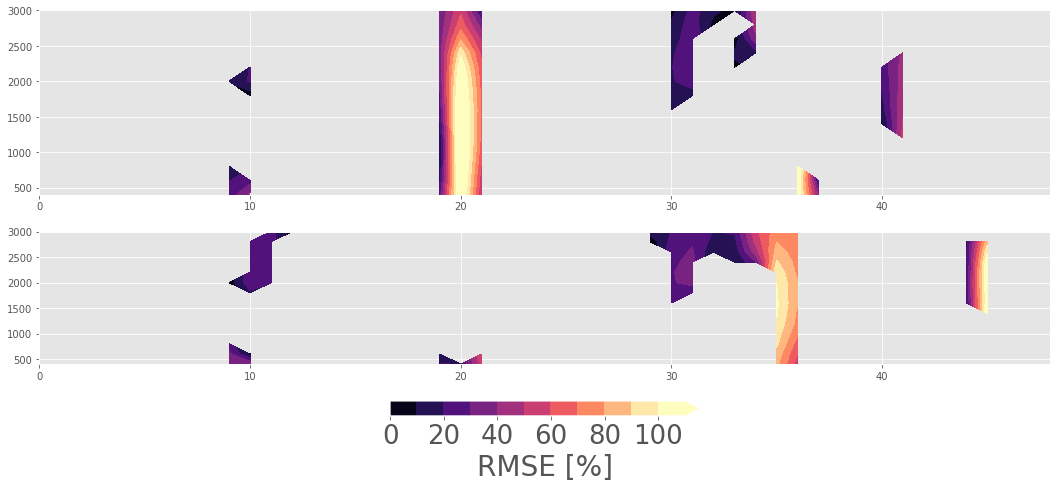

In [75]:
fig = plt.figure(figsize=(28.,40))

gs = GridSpec(10,3)
 
levels = np.arange(0,120,10)
for ens_memb in range(0,2):
    ax = plt.subplot(gs[ens_memb,:-1])
    im0 = ax.contourf(np.transpose(t_avg[0])[:Xmax,1:], np.asarray(h_avg[0])[:Xmax,1:], RMSE2[ens_memb], levels,
            cmap ='magma',extend = 'max', alpha = 1.0,
            vmin= 0., vmax= 100., origin= 'lower')
im.add_colorbar(fig,im0, ax, levels3[::2] ,var_label='RMSE [%]')
ax0.text(0.02,0.95, 'EM%s' %ens_memb ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', fontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':10})
ax0.xaxis.grid()
plt.show()
plt.close()

In [61]:
fig = plt.figure(figsize=(28.,40))

gs = GridSpec(10,3)
 
    # title
fig.suptitle('%s, %s %s %s' %(calday, day, calmon, year),x = 0.36, y=0.95, color =im.date_blue, fontsize = im.fontsize)
## 1st subplot --- 
for ens_memb in range(0,1):
 #   if np.size(RMSE2[ens_memb]) == 0:
  #      continue
   # else:
        ax0 = plt.subplot(gs[ens_memb,:-1])
            # Vertical line to show end of day
        ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
        ax0.axvline(24,color = spagh.vert_col, linewidth = 3)
        ax0.axvline(48,color = spagh.vert_col, linewidth = 3)
        im0 = ax.contourf(np.transpose(t_avg[0])[:Xmax,1:], np.asarray(h_avg[0])[:Xmax,1:], RMSE2[ens_memb],levels,
                      #cmap='seismic', extend = 'max', 
                      cmap='magma',extend = 'max', 
                      alpha = 1.0, 
                       vmin = 0., vmax = 100., origin = 'lower')
    ax0.text(0.02,0.95, 'EM%s' %ens_memb ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', fontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':10})
    ax0.xaxis.grid()
        
ax31 = plt.subplot(gs[3,-1])
cbaxes = fig.add_axes([0.685, .325, 0.017, 0.385])  # [left, bottom, width, height] 
im.add_colorbar2(fig,ax31, im0, cbaxes, levels, 'RMSE [%]')
plt.show()

IndentationError: unindent does not match any outer indentation level (<ipython-input-61-e16957b94ba4>, line 22)

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


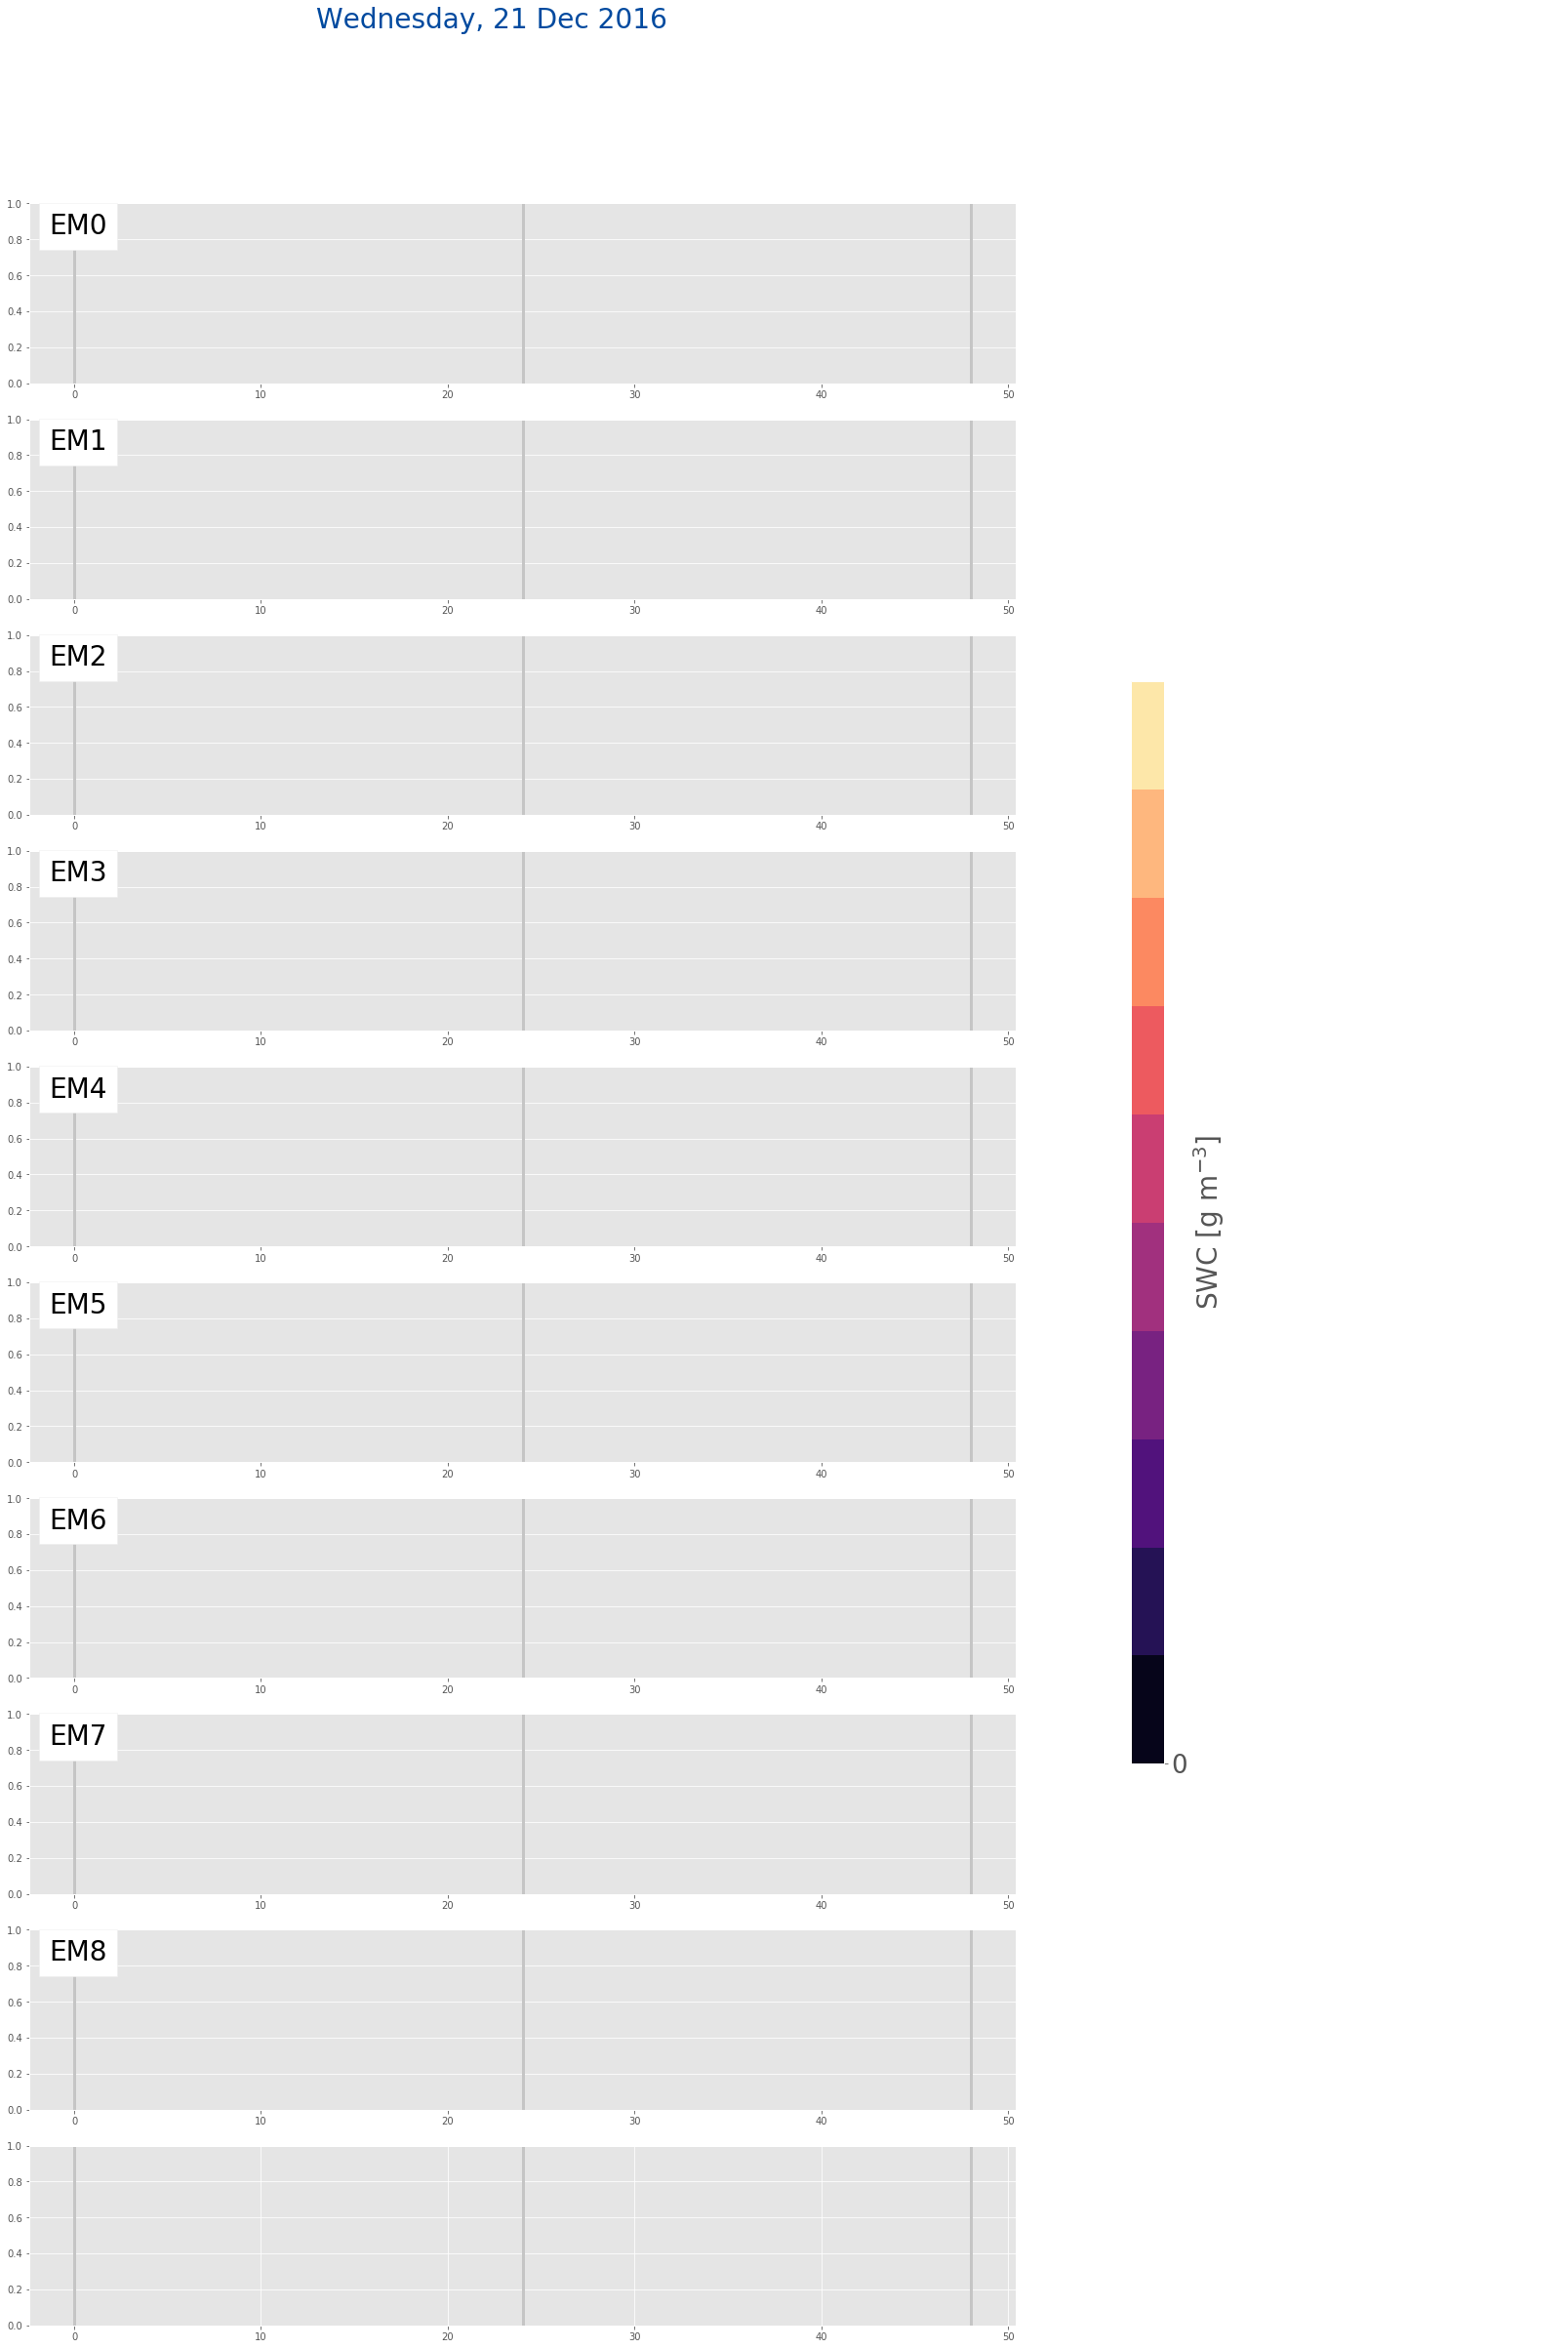

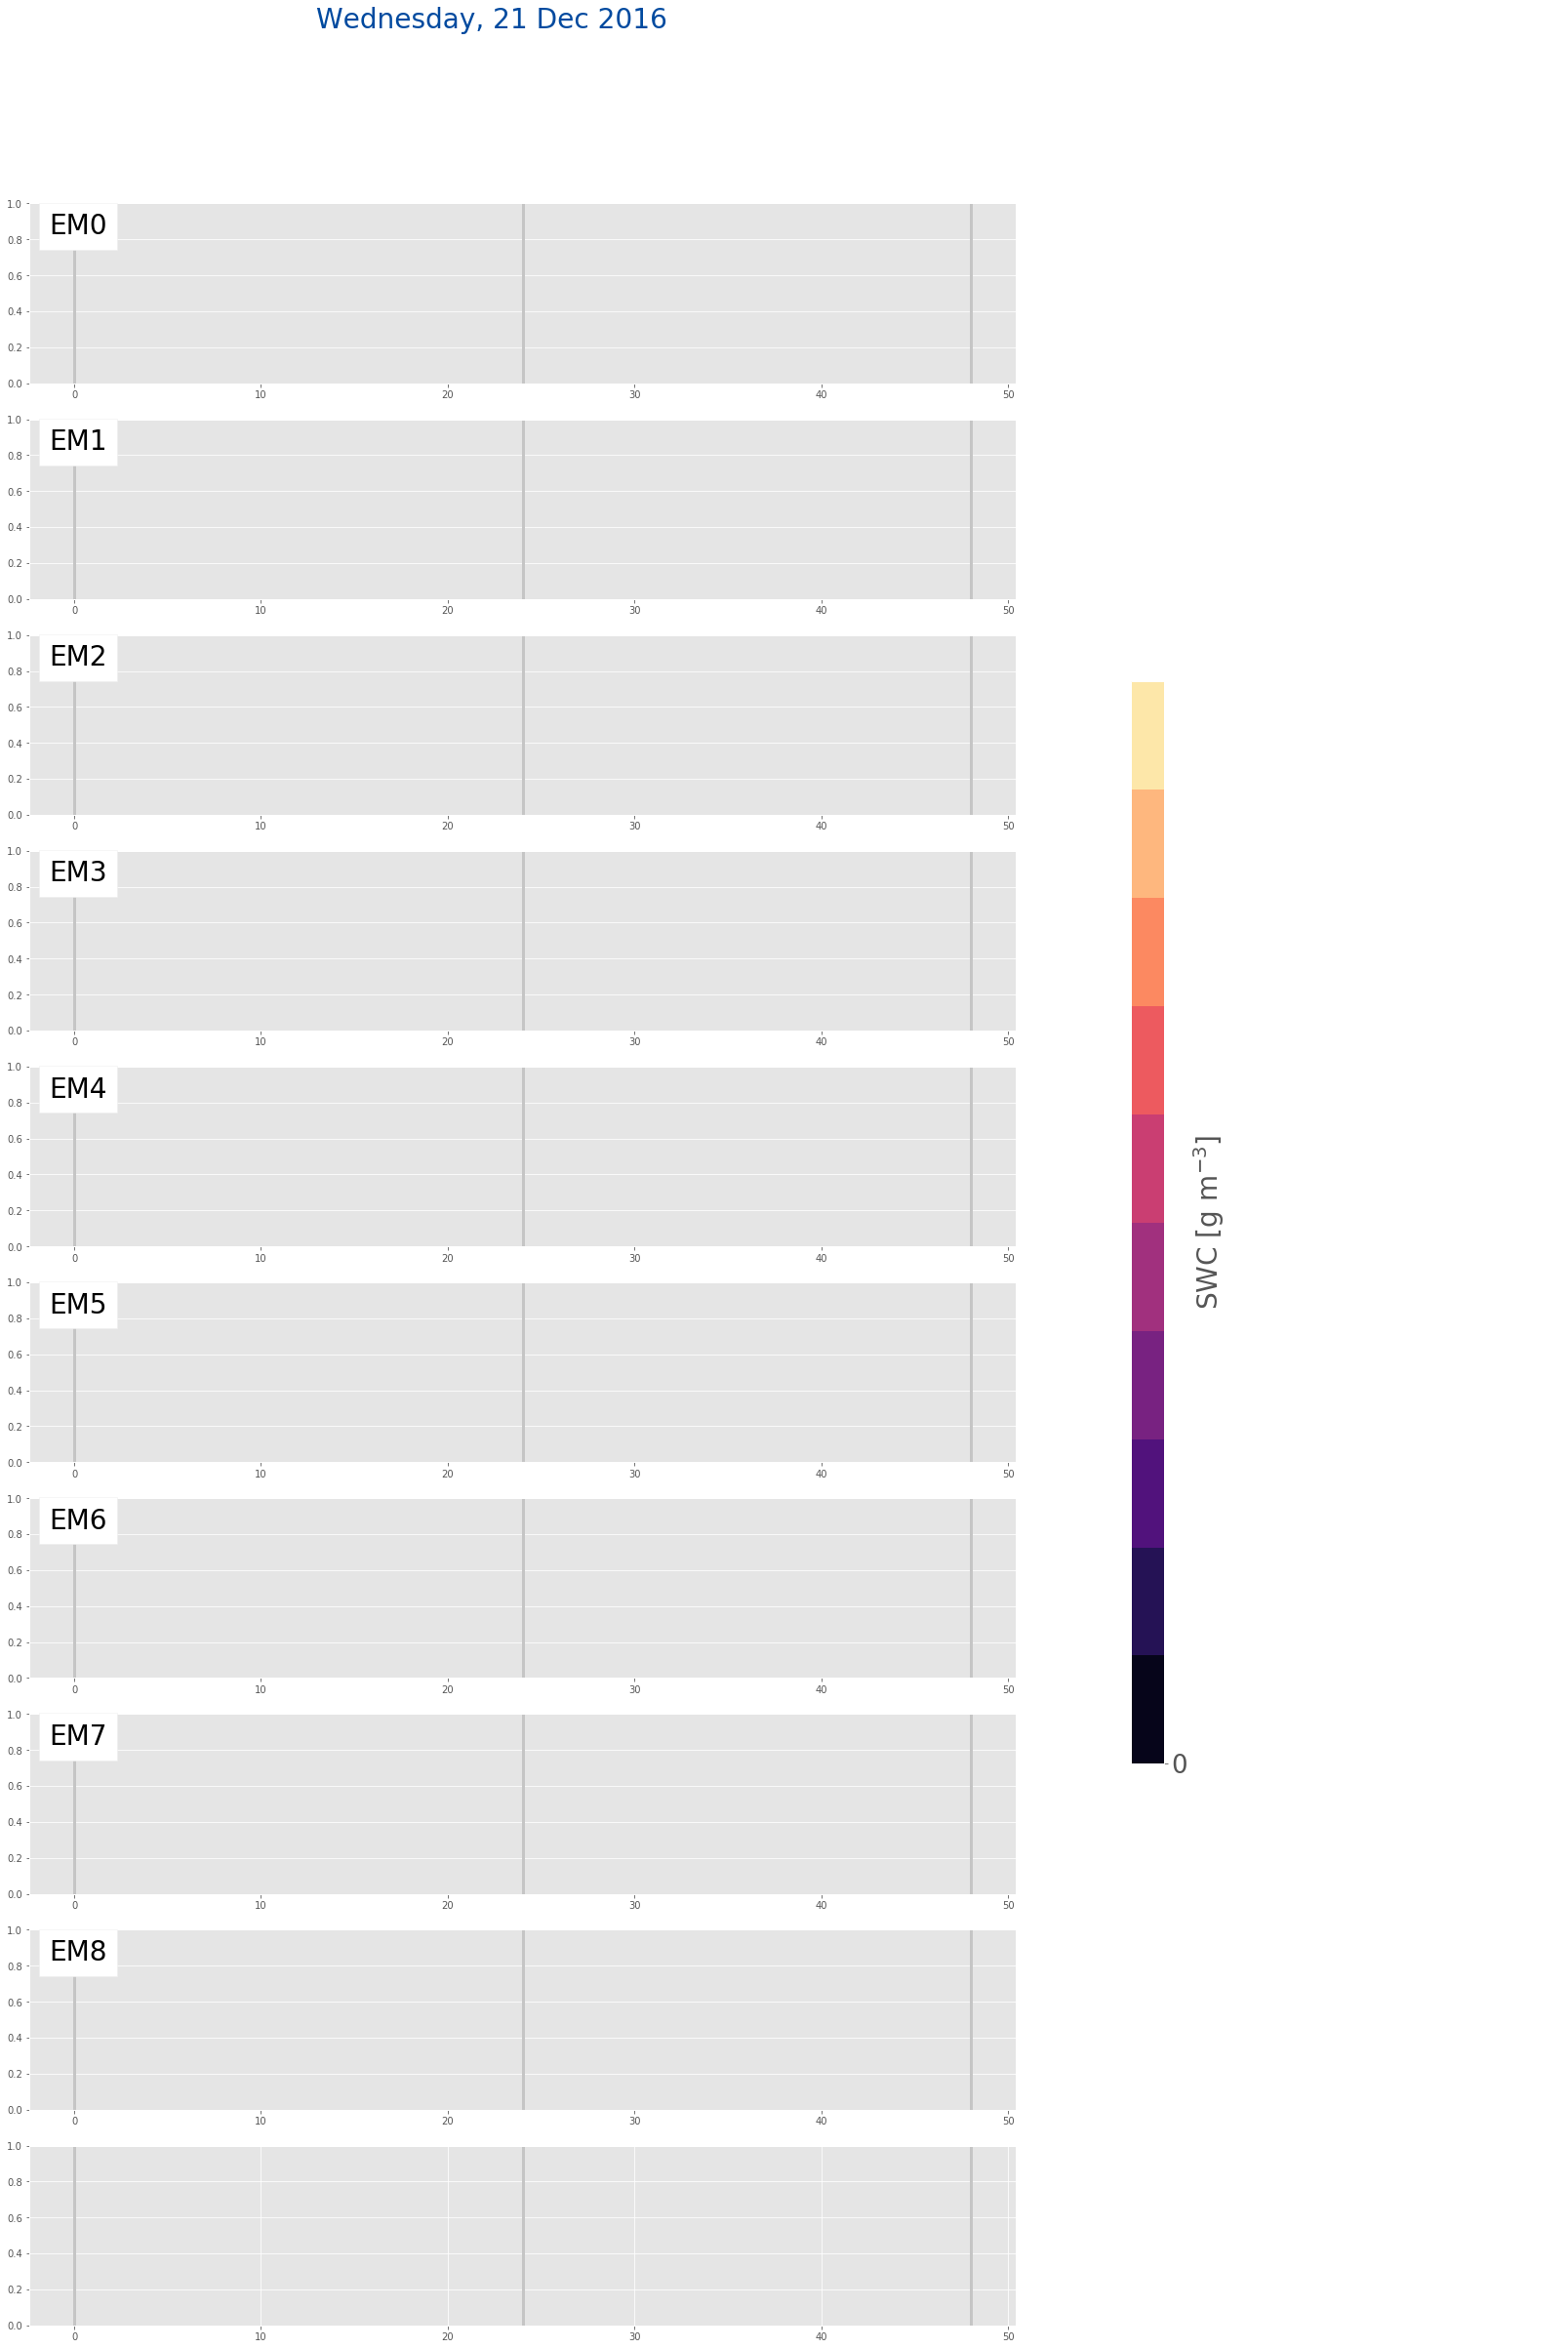

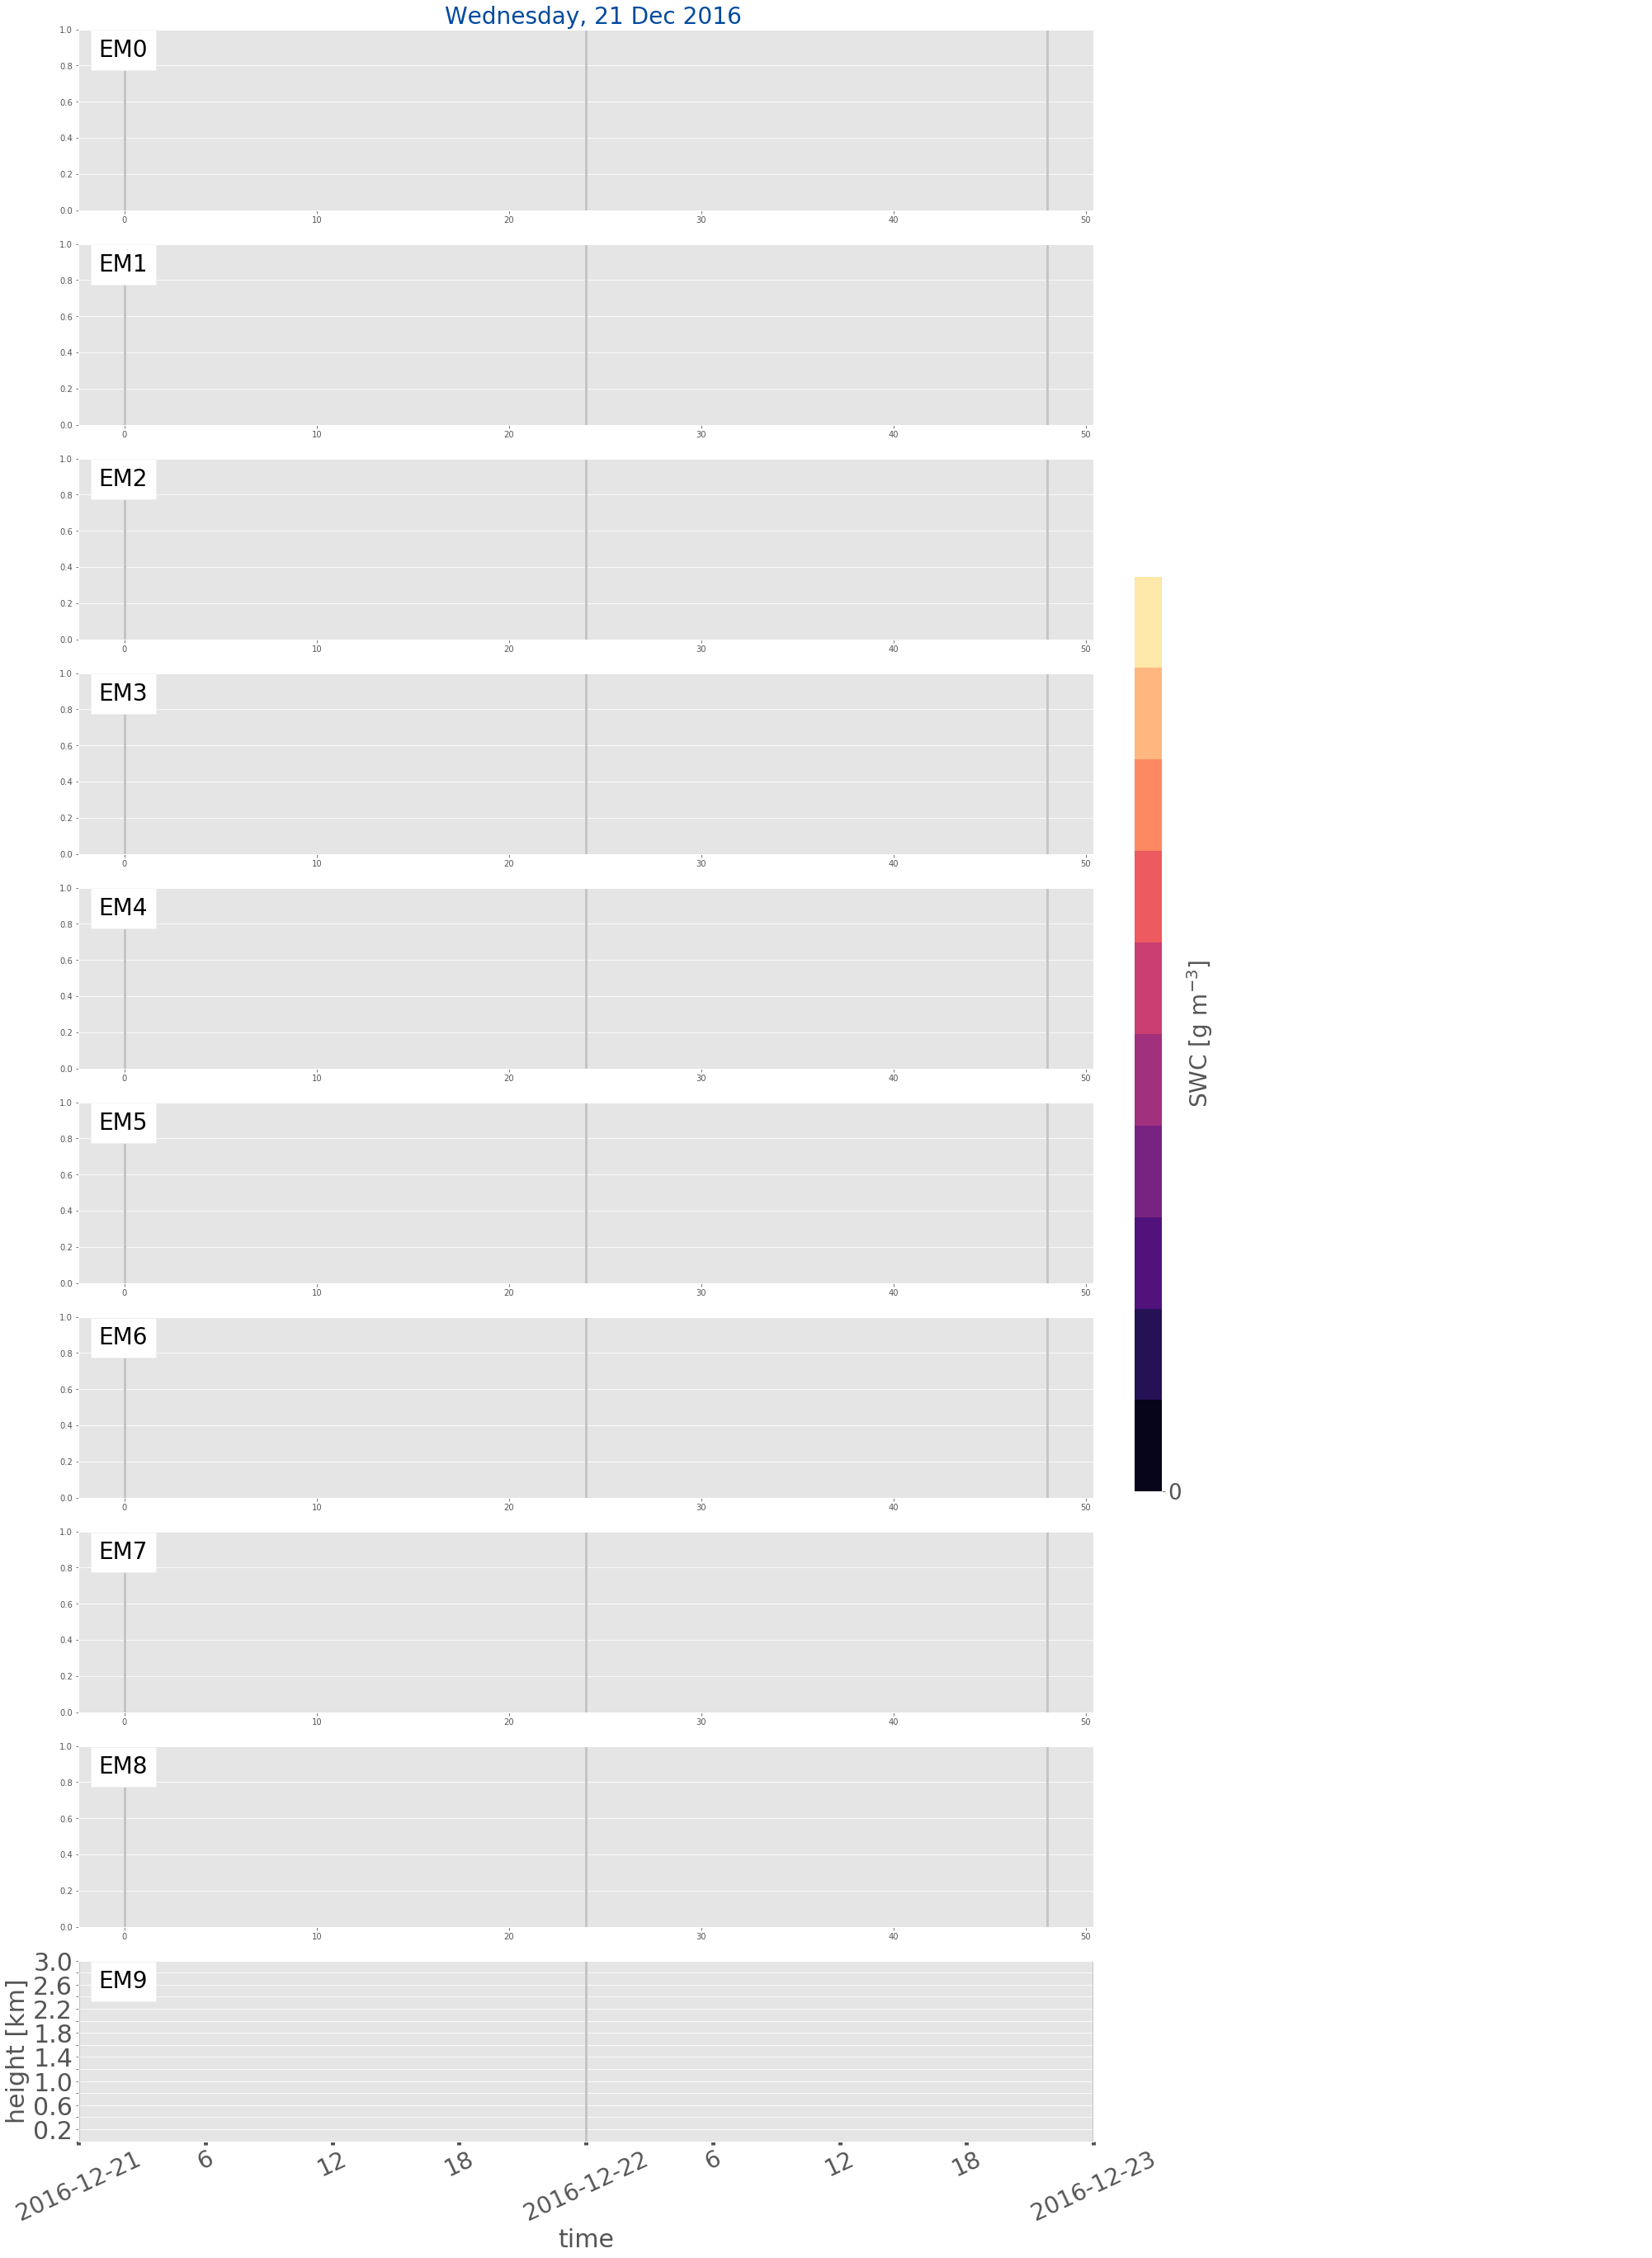

In [43]:
for ens_memb in range(9,10):
    if np.size(RMSE2[ens_memb]) == 0:
            continue
    else:
        ax0 = plt.subplot(gs[ens_memb,:-1])
            # Vertical line to show end of day
        ax0.axvline(0,color = spagh.vert_col, linewidth = 3)
        ax0.axvline(24,color = spagh.vert_col, linewidth = 3)
        ax0.axvline(48,color = spagh.vert_col, linewidth = 3)
        im0 = im.plt_ce_image(fig,ax0, np.transpose(t_avg[0])[:Xmax,1:], np.asarray(h_avg[0])[:Xmax,1:], RMSE2[ens_memb],
                                  levels3,
                v_min=0., v_max=100, xmax=48., ymax=3000.,
                xticks=np.arange(0,49,6), yticks=im.yticks1, cb_ticks = [],
                xlabel=xdays,var_label='',cb=0)
    ax0.text(0.02,0.95, 'EM%s' %ens_memb ,
            verticalalignment ='top', horizontalalignment='left',
             transform = ax0.transAxes,
             color = 'k', fontsize = im.fontsize,
             bbox={'facecolor':'white','alpha':1.,'pad':10})
    ax0.xaxis.grid()
    
    
    
    ################
plt.tight_layout(pad=1.4, w_pad=1.5, h_pad=1.5)
fig.subplots_adjust(top=0.94)

if savefig ==1:
    sF.save_figure_portrait(figdir, fig_name, form)
    print('saved: %s/%s' %(figdir, fig_name))
else:
    plt.show()
plt.close()